In [3]:
#----------------------- IMPORTING PACKAGES ---------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, chi2

In [6]:
#----------------------- LOADING THE DATA ---------------------------
data = pd.read_csv("heart_failure_dataset.csv")
wanted_features = ["serum_sodium", "ejection_fraction", "serum_creatinine"]
clean_data = data.drop("DEATH_EVENT", axis = 1)
clean_data1 = clean_data.drop("time", axis = 1)
targets = data["DEATH_EVENT"]

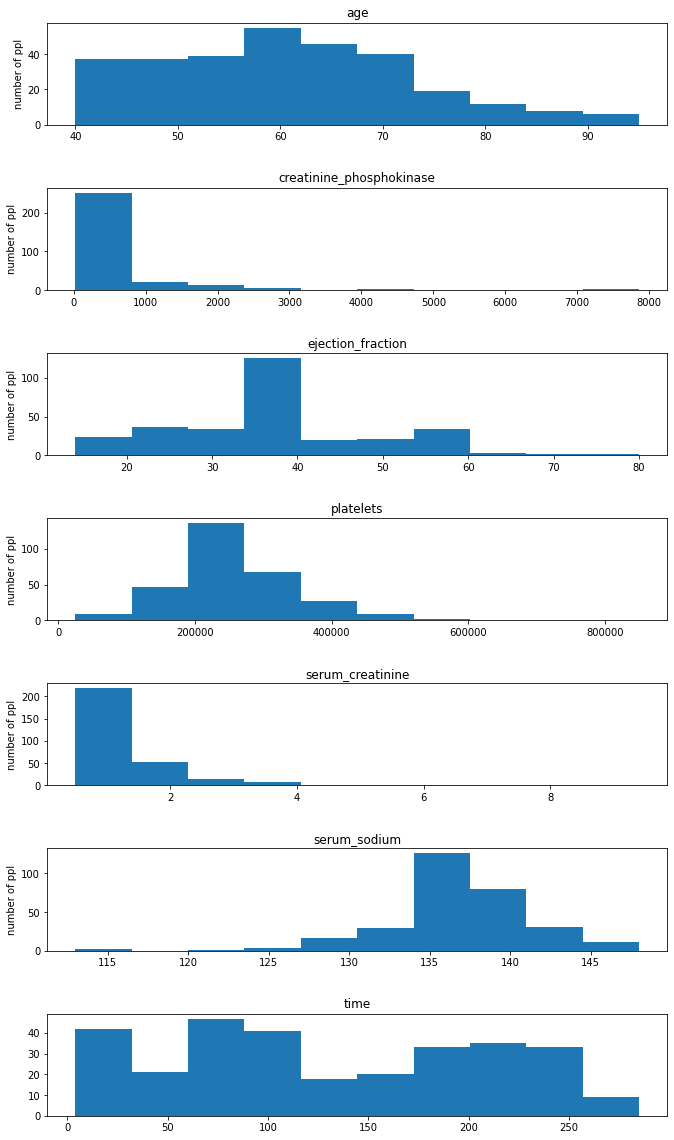

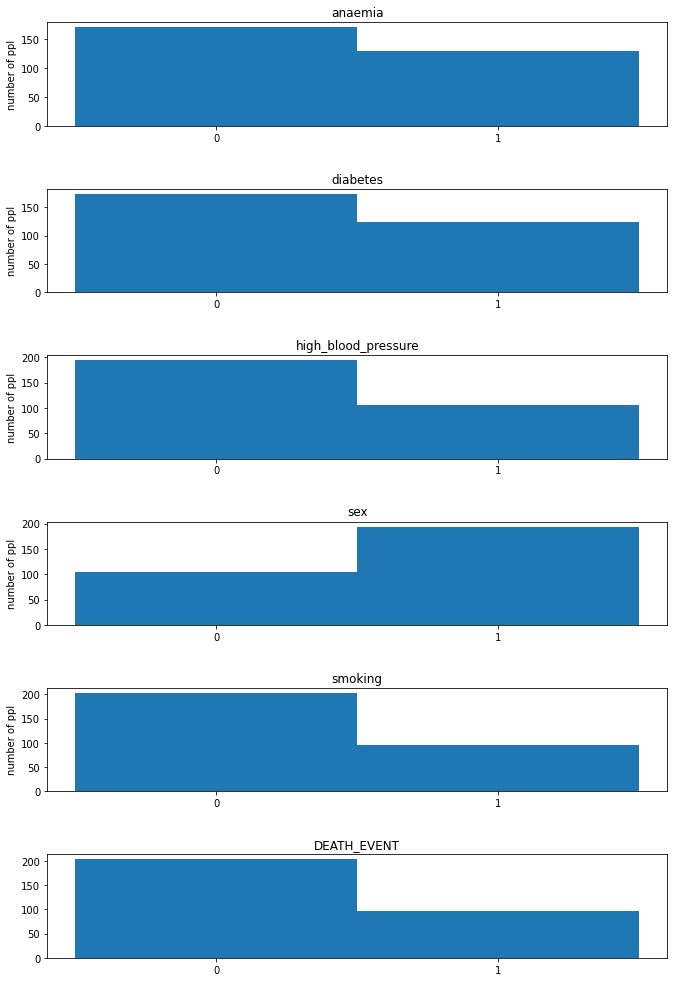

In [3]:
#----------------------- VISUALIZING THE DATA ---------------------------

# Some fine histograms
columns_cont = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"]
columns_bin = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking", "DEATH_EVENT"]
plt.figure(figsize=(10, 30))
n = 1

# Some fine histograms 

for i in columns_cont:
    plt.ylabel("number of ppl")
    plt.tight_layout(pad=3.0)
    plt.subplot(13,1,int(n))
    plt.title(i)
    plt.hist(data[i])
    n += 1

plt.figure(figsize=(10, 30))
for i in columns_bin:
    plt.ylabel("number of ppl")
    plt.tight_layout(pad=3.0)
    plt.subplot(13,1,int(n))
    plt.title(i)
    plt.hist(data[i], bins=[-.5,.5,1.5])
    plt.xticks((0,1))
    n += 1

C:\Users\mille\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\mille\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0, 0.5, 't-SNE feature 1')

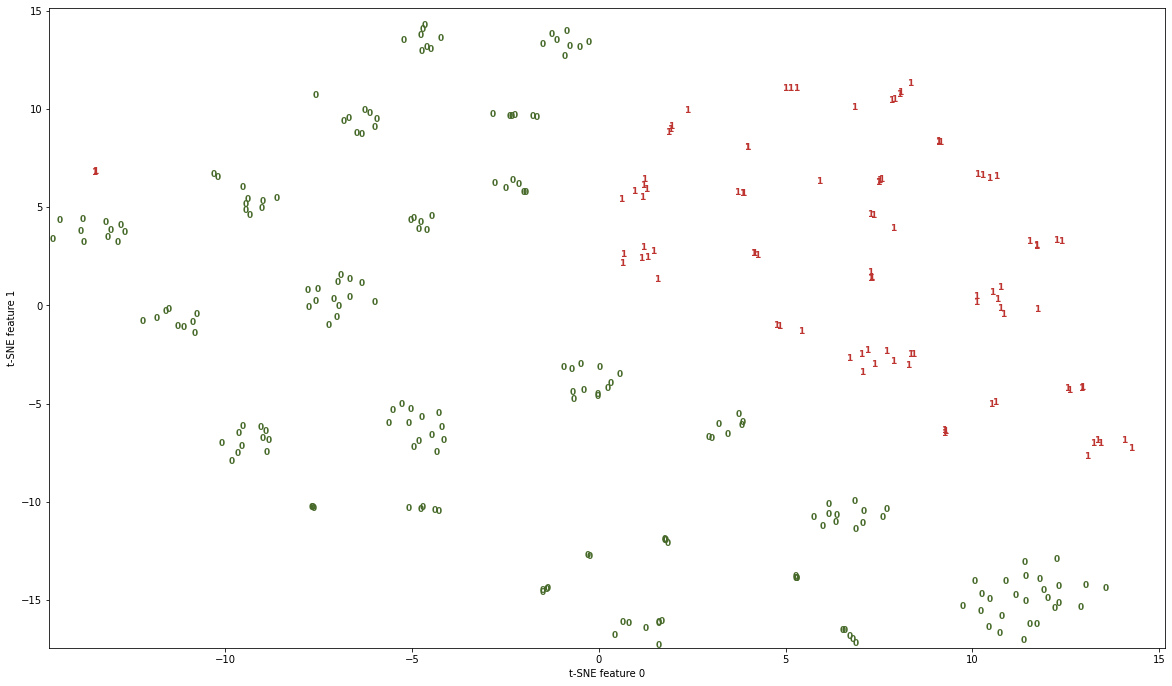

In [37]:
#------------- VISUALIZING THE DATA -------------
from sklearn.manifold import TSNE

#Using T-sne this time. 
# 1 = death
#extremly interesting https://distill.pub/2016/misread-tsne/

targets = data["DEATH_EVENT"]

colors = ["#476A2A","#BD3430", "#7851B8", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

#normalized_df=(data-data.mean())/data.std()
normalized_df=(data-data.min())/(data.max()-data.min())
tsne = TSNE(random_state = 1, perplexity = 30, n_iter = 5000)  # n_iter 5000 seem to have stabelized the plot. 

data_tsne = tsne.fit_transform(normalized_df) 


plt.figure(figsize=(20, 40))
plt.subplot(3,1,1)
plt.xlim(data_tsne[:, 0].min(), data_tsne[:, 0].max() + 1)
plt.ylim(data_tsne[:, 1].min(), data_tsne[:, 1].max() + 1)


for i in range(len(data)):
    # actually plot the digits as text instead of using scatter
    plt.text(data_tsne[i, 0], data_tsne[i, 1], str(targets[i]),
             color = colors[targets[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

In [5]:
#----------------------- PEARSON CORRELATION MATRIX ---------------------------

corr = data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

C:\Users\mille\AppData\Local\Temp\ipykernel_20356\2554327354.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.00,0.09,-0.08,-0.10,0.06,0.09,-0.05,0.16,-0.05,0.07,0.02,-0.22,0.25
anaemia,0.09,1.00,-0.19,-0.01,0.03,0.04,-0.04,0.05,0.04,-0.09,-0.11,-0.14,0.07
creatinine_phosphokinase,-0.08,-0.19,1.00,-0.01,-0.04,-0.07,0.02,-0.02,0.06,0.08,0.00,-0.01,0.06
diabetes,-0.10,-0.01,-0.01,1.00,-0.00,-0.01,0.09,-0.05,-0.09,-0.16,-0.15,0.03,-0.00
ejection_fraction,0.06,0.03,-0.04,-0.00,1.00,0.02,0.07,-0.01,0.18,-0.15,-0.07,0.04,-0.27
high_blood_pressure,0.09,0.04,-0.07,-0.01,0.02,1.00,0.05,-0.00,0.04,-0.10,-0.06,-0.20,0.08
platelets,-0.05,-0.04,0.02,0.09,0.07,0.05,1.00,-0.04,0.06,-0.13,0.03,0.01,-0.05
serum_creatinine,0.16,0.05,-0.02,-0.05,-0.01,-0.00,-0.04,1.00,-0.19,0.01,-0.03,-0.15,0.29
serum_sodium,-0.05,0.04,0.06,-0.09,0.18,0.04,0.06,-0.19,1.00,-0.03,0.00,0.09,-0.20
sex,0.07,-0.09,0.08,-0.16,-0.15,-0.10,-0.13,0.01,-0.03,1.00,0.45,-0.02,-0.00


Confusion Matrix for best model w/ all features
       t\p   Survived     Died 
    Survived    57.00     4.00 
        Died     8.00     6.00 
Confusion Matrix for best model w/ some features
       t\p   Survived     Died 
    Survived    45.00     6.00 
        Died     8.00    16.00 
Features that the best model used:  ['ejection_fraction', 'serum_creatinine'] 

Chosen depth in model with all features:  2
Chosen depth in model with some features:  8
Mean accuracy using all features:  0.7155555555555557
Mean accuracy using best features:  0.7194612794612794
Mean accuracy when always guessing survival: 0.672053872053872


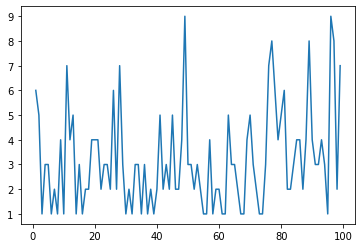

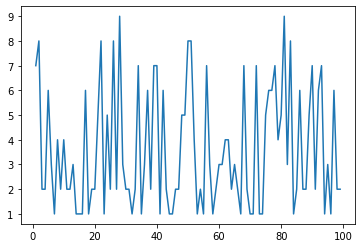

In [7]:
#----------------------- DECISION TREE ---------------------------
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    """taken from https://gist.github.com/zachguo/10296432"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t\p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

accuracies_all_tree = []
accuracies_feat_tree = []
accuracies_always_true = []
depth_all_list = []
depth_feat_list = []
best_model_all = {"score": 0, "features": [], "prediction": None, "true": None, "depth": None}
best_model_feat = {"score": 0, "features": [], "prediction": None, "true": None, "depth": None}

n = 100

for i in range(1,n):
    
    # -----> 1. splitting the data ----->
    x_trainval, x_test, y_trainval, y_test = train_test_split(clean_data1, targets)
    x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval)
   

    # -----> 2. extracting features ----->
    K_best = SelectKBest(f_classif, k = 2)
    selected_features = K_best.fit_transform(x_train, y_train)
    
    #extracting the k best category names and printing them
    sup = K_best.get_support()
    featurenames = clean_data1.columns
    wanted_features = []
    ##print("Features selected are:")
    for nn in np.where(sup)[0]:
        ##print(featurenames[nn])
        wanted_features.append(featurenames[nn])
    
    #creating datasets containing only the wanted features
    x_test_feat = x_test[wanted_features]
    x_trainval_feat = x_trainval[wanted_features]
    x_train_feat = x_train[wanted_features]
    x_val_feat = x_val[wanted_features]
    

    # -----> 3. Validating,finding best params ----->
    best_score_all = 0
    best_score_feat = 0
    n2 = 10

    for j in range(1,n2):
        # for each parameter, train a tree
        tree = DecisionTreeClassifier(max_depth= j, random_state=0) 
        
        #fit the tree with ALL features. 
        tree.fit(x_train, y_train)
        # evaluate the tree on the validation set
        score_all = tree.score(x_val, y_val)
        # if we got a better score, store the score and parameters
        if score_all > best_score_all:
            best_score_all = score_all
            best_parameter_all = j

        #fit the tree with BEST features. 
        tree.fit(x_train_feat, y_train)
        # evaluate the tree on the validation set
        score_feat = tree.score(x_val_feat, y_val)
        # if we got a better score, store the score and parameters
        if score_feat > best_score_feat:
            best_score_feat = score_feat
            best_parameter_feat = j
    depth_all_list.append(best_parameter_all)
    depth_feat_list.append(best_parameter_feat)

    # -----> 4. Fitting the model ----->
    # rebuild a model on the combined training and validation set, for ALL and BEST features respectively.
    # and evaluate it on the test set, for ALL and BEST features respectively.

    tree_all = DecisionTreeClassifier(max_depth= best_parameter_all, random_state=0)
    tree_all.fit(x_trainval, y_trainval)
    
    tree_feat = DecisionTreeClassifier(max_depth= best_parameter_feat, random_state=0)
    tree_feat.fit(x_trainval_feat, y_trainval)
    

    # -----> 5. Evaluating on test data sets ----->
    test_score_all = tree_all.score(x_test,y_test)
    accuracies_all_tree.append(test_score_all)

    test_score_feat = tree_feat.score(x_test_feat,y_test)
    accuracies_feat_tree.append(test_score_feat)
    
    if test_score_all > best_model_all["score"]:
        best_model_all["score"] = test_score_all
        best_model_all["true"] = y_test
        best_model_all["prediction"] = tree_all.predict(x_test)
        best_model_all["depth"] = best_parameter_all

    if test_score_feat > best_model_feat["score"]:
        best_model_feat["score"] = test_score_feat
        best_model_feat["true"] = y_test
        best_model_feat["prediction"] = tree_feat.predict(x_test_feat)
        best_model_feat["features"] = wanted_features
        best_model_feat["depth"] = best_parameter_feat

    len_y = len(y_test)
    alw = np.full((1,len_y),0)
    accuracies_always_true.append(accuracy_score(alw.T, y_test))

print("Confusion Matrix for best model w/ all features")
print_cm(confusion_matrix(best_model_all["true"], best_model_all["prediction"]), ["Survived", "Died"])

print("Confusion Matrix for best model w/ some features")
print_cm(confusion_matrix(best_model_feat["true"], best_model_feat["prediction"]), ["Survived", "Died"])

print("Features that the best model used: ", best_model_feat["features"], "\n")

print("Chosen depth in model with all features: ", best_model_all["depth"])
print("Chosen depth in model with some features: ", best_model_feat["depth"])
print("Mean accuracy using all features: ", np.mean(accuracies_all_tree))
print("Mean accuracy using best features: ", np.mean(accuracies_feat_tree))
print("Mean accuracy when always guessing survival:", np.mean(accuracies_always_true))


plt.plot(range(1,n), depth_all_list)
plt.show()
plt.plot(range(1,n), depth_feat_list)



Confusion Matrix for best model w/ all features
       t\p   Survived     Died 
    Survived    55.00     3.00 
        Died    15.00     2.00 
Confusion Matrix for best model w/ some features
       t\p   Survived     Died 
    Survived    53.00     5.00 
        Died     8.00     9.00 
Features that the best model used:  ['ejection_fraction', 'serum_creatinine'] 

Mean accuracy using all features:  0.6346127946127945
Mean accuracy using best features:  0.7018181818181817
Mean accuracy when always guessing survival: 0.681885521885522


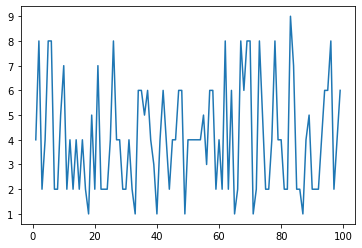

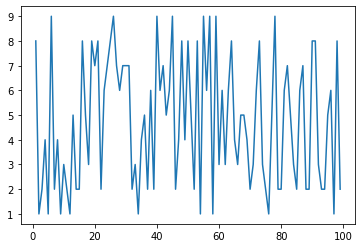

In [8]:
#----------------------- KNearestNeighbor ---------------------------

from sklearn.neighbors import KNeighborsClassifier

accuracies_all_knn = []
accuracies_feat_knn = []
accuracies_always_true = []
k_all_list = []
k_feat_list = []
best_model_all = {"score": 0, "features": [], "prediction": None, "true": None}
best_model_feat = {"score": 0, "features": [], "prediction": None, "true": None}

n = 100

for i in range(1,n):
    
    # -----> 1. splitting the data ----->
    x_trainval, x_test, y_trainval, y_test = train_test_split(clean_data1, targets)
    x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval)
   
    # -----> 2. extracting features ----->
    K_best = SelectKBest(f_classif, k = 2)
    selected_features = K_best.fit_transform(x_train, y_train)
    
    #extracting the k best category names and printing them
    sup = K_best.get_support()
    featurenames = clean_data1.columns
    wanted_features = []

    for nn in np.where(sup)[0]:
        wanted_features.append(featurenames[nn])

    #creating datasets containing only the wanted features
    x_test_feat = x_test[wanted_features]
    x_trainval_feat = x_trainval[wanted_features]
    x_train_feat = x_train[wanted_features]
    x_val_feat = x_val[wanted_features]

    # -----> 3. Validating,finding best params ----->
    best_score_all = 0
    best_score_feat = 0
    n2 = 10

    for j in range(1,n2):
        # for each parameter, train a KNN Classifier
        clf = KNeighborsClassifier(n_neighbors = j) 
        
        #fit the classifier with ALL features. 
        clf.fit(x_train, y_train)
        # evaluate the classifier on the validation set
        score_all = clf.score(x_val, y_val)
        # if we got a better score, store the score and parameters
        if score_all > best_score_all:
            best_score_all = score_all
            best_parameter_all = j

        #fit the classifier with BEST features. 
        clf.fit(x_train_feat, y_train)
        # evaluate the classifier on the validation set
        score_feat = clf.score(x_val_feat, y_val)
        # if we got a better score, store the score and parameters
        if score_feat > best_score_feat:
            best_score_feat = score_feat
            best_parameter_feat = j

    k_all_list.append(best_parameter_all)
    k_feat_list.append(best_parameter_feat)

    # -----> 4. Fitting the model ----->
    # rebuild a model on the combined training and validation set, for ALL and BEST features respectively.
    # and evaluate
    knn_all = KNeighborsClassifier(n_neighbors = best_parameter_all)
    knn_all.fit(x_trainval, y_trainval)

    knn_feat = KNeighborsClassifier(n_neighbors = best_parameter_feat)
    knn_feat.fit(x_trainval_feat, y_trainval) 


   # 5. -----> Evaluating on test data sets ----->
    test_score_all = knn_all.score(x_test,y_test)
    accuracies_all_knn.append(test_score_all)

    test_score_feat = knn_feat.score(x_test_feat,y_test)
    accuracies_feat_knn.append(test_score_feat)

    if test_score_all > best_model_all["score"]:
        best_model_all["score"] = test_score_all
        best_model_all["true"] = y_test
        best_model_all["prediction"] = knn_all.predict(x_test)

    if test_score_feat > best_model_feat["score"]:
        best_model_feat["score"] = test_score_feat
        best_model_feat["true"] = y_test
        best_model_feat["prediction"] = knn_feat.predict(x_test_feat)
        best_model_feat["features"] = wanted_features

    len_y = len(y_test)
    alw = np.full((1,len_y),0)
    accuracies_always_true.append(accuracy_score(alw.T, y_test))

print("Confusion Matrix for best model w/ all features")
print_cm(confusion_matrix(best_model_all["true"], best_model_all["prediction"]), ["Survived", "Died"])

print("Confusion Matrix for best model w/ some features")
print_cm(confusion_matrix(best_model_feat["true"], best_model_feat["prediction"]), ["Survived", "Died"])

print("Features that the best model used: ", best_model_feat["features"], "\n")


print("Mean accuracy using all features: ", np.mean(accuracies_all_knn))
print("Mean accuracy using best features: ", np.mean(accuracies_feat_knn))
print("Mean accuracy when always guessing survival:", np.mean(accuracies_always_true))

plt.plot(range(1,n), k_all_list)
plt.show()
plt.plot(range(1,n), k_feat_list)

Confusion Matrix for best model w/ all features
       t\p   Survived     Died 
    Survived    58.00     0.00 
        Died    17.00     0.00 
Confusion Matrix for best model w/ some features
       t\p   Survived     Died 
    Survived    44.00     8.00 
        Died     6.00    17.00 
Features that the best model used:  ['age', 'ejection_fraction'] 

Mean accuracy using all features:  0.6719191919191919
Mean accuracy using best features:  0.6874074074074075
Mean accuracy when always guessing survival: 0.6774410774410775


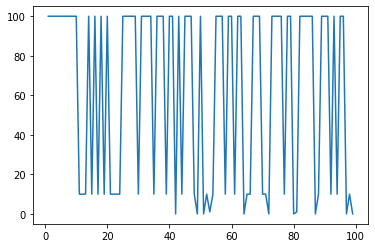

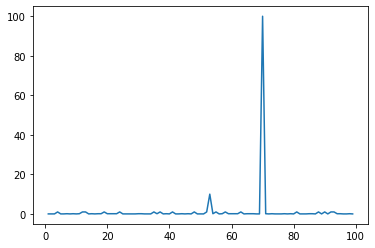

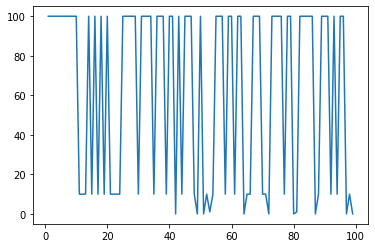

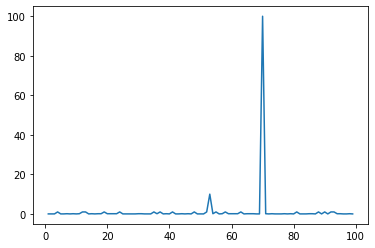

In [10]:
#----------------------- SVC ---------------------------

from sklearn.svm import SVC
accuracies_all_svc = []
accuracies_feat_svc = []
accuracies_always_true = []
best_model_all = {"score": 0, "features": [], "prediction": None, "true": None, "gamma": [], "C": []}
best_model_feat = {"score": 0, "features": [], "prediction": None, "true": None, "gamma": [], "C": []}

n = 100

normalized_df=(clean_data1-clean_data1.min())/(clean_data1.max()-clean_data1.min())

for i in range(1,n):
    
    # -----> 1. splitting the data ----->
    x_trainval, x_test, y_trainval, y_test = train_test_split(normalized_df, targets)
    x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval)
   

    # -----> 2. extracting features ----->
    K_best = SelectKBest(f_classif, k = 2)
    selected_features = K_best.fit_transform(x_train, y_train)
    
    #extracting the k best category names and printing them
    sup = K_best.get_support()
    featurenames = clean_data1.columns
    wanted_features = []
    ##print("Features selected are:")
    for nn in np.where(sup)[0]:
        ##print(featurenames[nn])
        wanted_features.append(featurenames[nn])
    
    #creating datasets containing only the wanted features
    x_test_feat = x_test[wanted_features]
    x_trainval_feat = x_trainval[wanted_features]
    x_train_feat = x_train[wanted_features]
    x_val_feat = x_val[wanted_features]
    
    
    # -----> 3. Validating,finding best params ----->
    best_score_all = 0
    best_score_feat = 0
    n2 = 10

    for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
        for C in [0.001, 0.01, 0.1, 1, 10, 100]:
            # for each combination of parameters, train an SVC
            svc = SVC(gamma=gamma, C=C)
            
            #fit the SVc with ALL features
            svc.fit(x_train, y_train)
            # evaluate the SVC on the validation set
            score_all = svc.score(x_val, y_val)
            # if we got a better score, store the score and parameters
            if score_all > best_score_all:
                best_score_all = score_all
                best_parameters_all = [C , gamma]


            #fit the SVc with BEST features
            svc.fit(x_train, y_train)
            # evaluate the SVC on the validation set
            score_feat = svc.score(x_val, y_val)
            # if we got a better score, store the score and parameters
            if score_feat > best_score_feat:
                best_score_feat = score_feat
                best_parameters_feat = [C , gamma]

    best_model_all["C"].append(best_parameters_all[0])
    best_model_all["gamma"].append(best_parameters_all[1])

    best_model_feat["C"].append(best_parameters_feat[0])
    best_model_feat["gamma"].append(best_parameters_feat[1])

    # -----> 4. Fitting the model ----->
    # rebuild a model on the combined training and validation set, for ALL and BEST features respectively.
    # and evaluate it on the test set, for ALL and BEST features respectively.

    svc_all = SVC(gamma = best_parameters_all[0], C = best_parameters_all[1])
    svc_all.fit(x_trainval, y_trainval)
    
    svc_feat = SVC(gamma = best_parameters_feat[0], C = best_parameters_feat[1])
    svc_feat.fit(x_trainval_feat, y_trainval)


    # -----> 5. Evaluating on test data sets ----->
    test_score_all = svc_all.score(x_test,y_test)
    accuracies_all_svc.append(test_score_all)

    test_score_feat = svc_feat.score(x_test_feat,y_test)
    accuracies_feat_svc.append(test_score_feat)

    if test_score_all > best_model_all["score"]:
        best_model_all["score"] = test_score_all
        best_model_all["true"] = y_test
        best_model_all["prediction"] = svc_all.predict(x_test)

    if test_score_feat > best_model_feat["score"]:
        best_model_feat["score"] = test_score_feat
        best_model_feat["true"] = y_test
        best_model_feat["prediction"] = svc_feat.predict(x_test_feat)
        best_model_feat["features"] = wanted_features

    len_y = len(y_test)
    alw = np.full((1,len_y),0)
    accuracies_always_true.append(accuracy_score(alw.T, y_test))

print("Confusion Matrix for best model w/ all features")
print_cm(confusion_matrix(best_model_all["true"], best_model_all["prediction"]), ["Survived", "Died"])

print("Confusion Matrix for best model w/ some features")
print_cm(confusion_matrix(best_model_feat["true"], best_model_feat["prediction"]), ["Survived", "Died"])

print("Features that the best model used: ", best_model_feat["features"], "\n")

print("Mean accuracy using all features: ", np.mean(accuracies_all_svc))
print("Mean accuracy using best features: ", np.mean(accuracies_feat_svc))
print("Mean accuracy when always guessing survival:", np.mean(accuracies_always_true))



plt.plot(range(1,n), best_model_all["C"])
plt.show()
plt.plot(range(1,n), best_model_all["gamma"])

plt.show()
plt.plot(range(1,n), best_model_feat["C"])
plt.show()
plt.plot(range(1,n), best_model_feat["gamma"])
